# Model evaluation

- To evaluate our model, we decided to choose accuracy as a metric
- Confusion matrix were plotted to diagnostic our networks 

## Dummy classifier

- To sanity check our pipeline, we trained a dummy classifier. It should predict 1/57 = 0.0175438596

In [1]:
%cd ../app/

from app.main import load_dataset, train_test_split, dataset_augmentation, feature_extractor, LOAD_SESSION, RANDOM_SEED, PONDERATION
from app.fusion import train, evaluate
from app.visualization import plot_confusion_matrix
import numpy as np

%cd ..

/home/bouteille/Documents/iml-project/app
/home/bouteille/Documents/iml-project


In [2]:
print('Loading dataset...')
dataset, labels = load_dataset("./dataset/train")

print('Dataset augmentation...')
dataset_aug, labels_aug = dataset_augmentation(
    dataset, labels, transformation_per_image=5)

img_train, img_test, label_train, label_test = train_test_split(
    dataset_aug, labels_aug, test_size=0.2, random_state=RANDOM_SEED, stratify=labels_aug)

print("Create feature extractor ...\n")
color_feature_extractor, shape_feature_extractor = feature_extractor(
    img_train, load_session=LOAD_SESSION, mode="moments")

Loading dataset...
Dataset augmentation...
Create feature extractor ...

Mode Hu moments ...


In [3]:
from sklearn.dummy import DummyClassifier

clf = DummyClassifier() 
train(clf, color_feature_extractor(img_train), label_train)
prediction, accuracy = evaluate(clf, color_feature_extractor(img_test), label_test)
print(accuracy)

0.017543859649122806


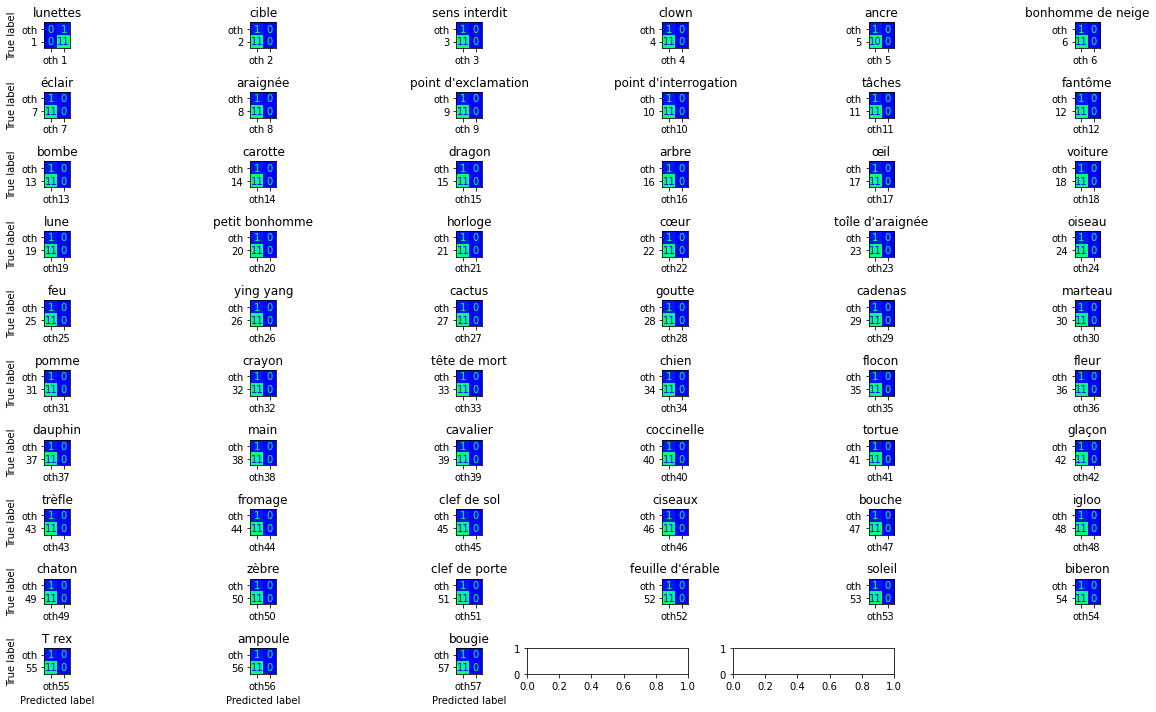

In [4]:
plot_confusion_matrix("./dataset/labels.txt", prediction, label_test)

## Train Color descriptor alone

In [5]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=5)

In [6]:
train(clf, color_feature_extractor(img_train), label_train)
prediction, accuracy = evaluate(clf, color_feature_extractor(img_test), label_test)
print(accuracy)

0.9952153110047847


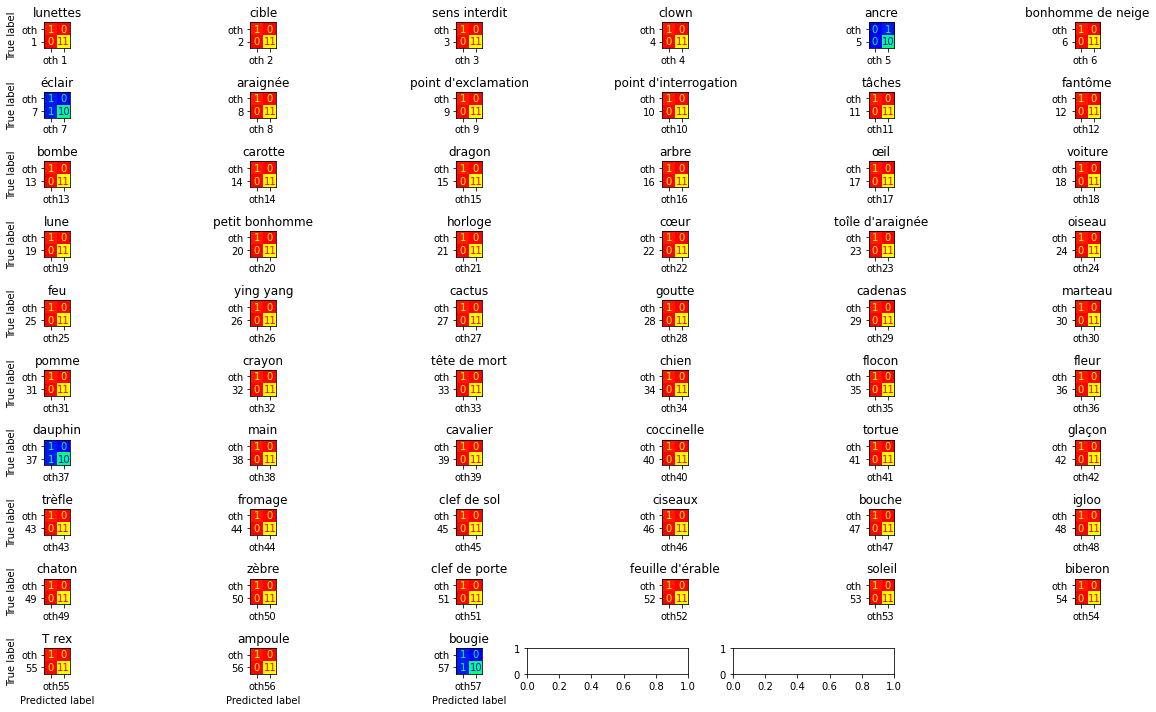

In [7]:
plot_confusion_matrix("./dataset/labels.txt", prediction, label_test)

# Train Shape descriptor

- Hu moments

In [8]:
clf = RandomForestClassifier(max_depth=5)
_, shape_feature_extractor = feature_extractor(img_train, load_session=LOAD_SESSION, mode="moments")

Mode Hu moments ...


In [9]:
train(clf, shape_feature_extractor(img_train), label_train)
prediction, accuracy = evaluate(clf, shape_feature_extractor(img_test), label_test)
print(accuracy)

0.9776714513556619


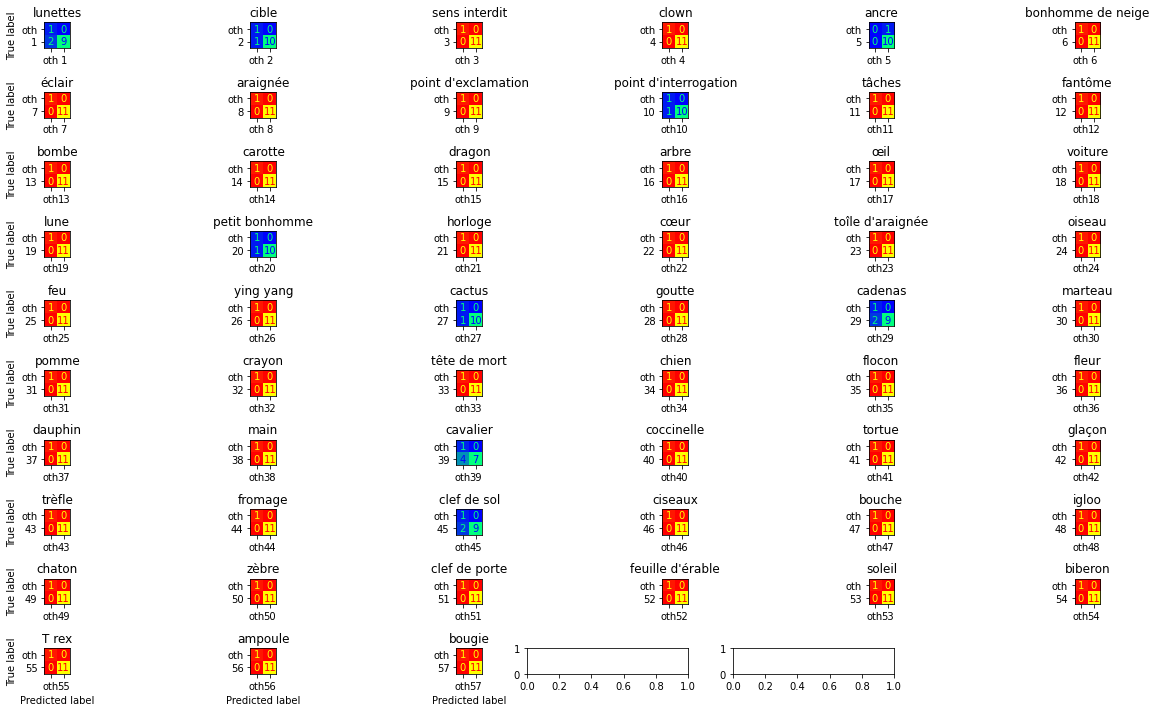

In [10]:
plot_confusion_matrix("./dataset/labels.txt", prediction, label_test)

- Orb

In [22]:
clf = RandomForestClassifier(max_depth=8)
_, shape_feature_extractor = feature_extractor(img_train, load_session=LOAD_SESSION, mode="orb")

Mode ORB ...


KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 177, in where
KeyboardInterrupt: 


In [ ]:
train(clf, shape_feature_extractor(img_train), label_train)
prediction, accuracy = evaluate(clf, shape_feature_extractor(img_test), label_test)
print(accuracy)

0.4194577352472089


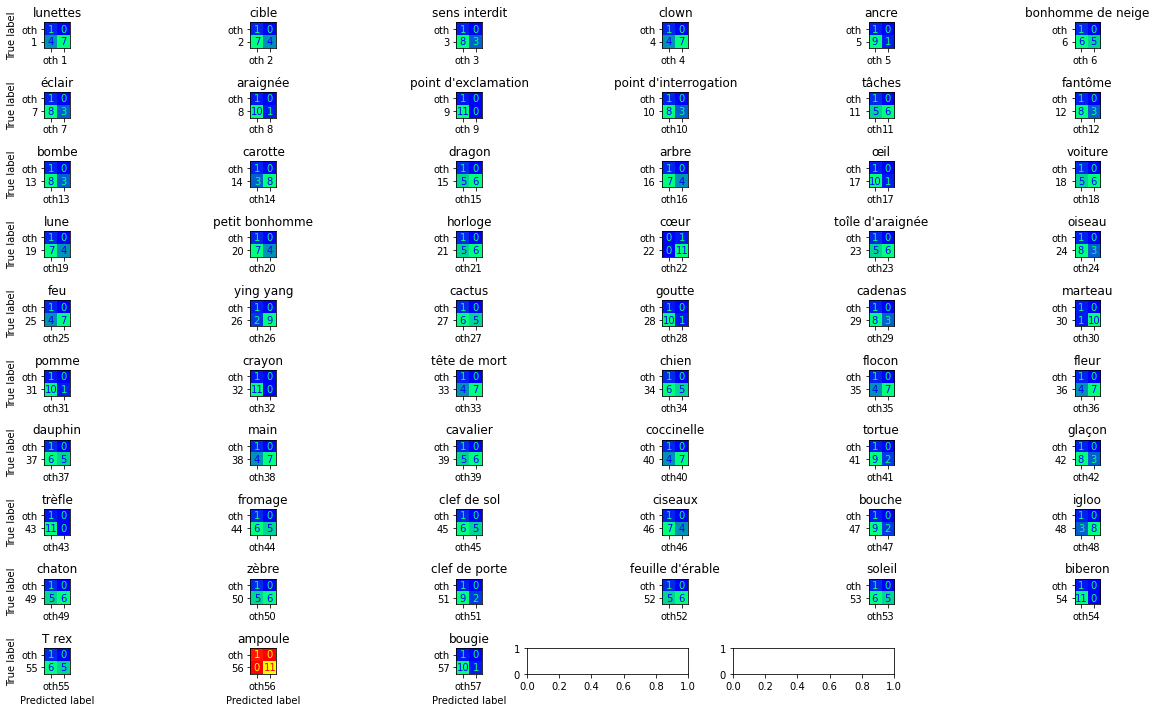

In [13]:
plot_confusion_matrix("./dataset/labels.txt", prediction, label_test)

# Train color descriptor + Shape descriptor (Hu moment)

Early fusion

In [14]:
clf = RandomForestClassifier(max_depth=5)

In [15]:
color_feature_extractor, shape_feature_extractor = feature_extractor(img_train, load_session=LOAD_SESSION, mode="moments")

def feature_extractor_fusion(color_feature_extractor, shape_feature_extractor):
    return lambda img: np.hstack((color_feature_extractor(img) * PONDERATION, shape_feature_extractor(img) * (1 - PONDERATION)))

fused_feature_extractor = feature_extractor_fusion(
        color_feature_extractor, shape_feature_extractor)

feature_train = fused_feature_extractor(img_train)
feature_test = fused_feature_extractor(img_test)

Mode Hu moments ...


In [16]:
train(clf, feature_train, label_train)
prediction, accuracy = evaluate(clf, feature_test, label_test)
print(accuracy)

1.0


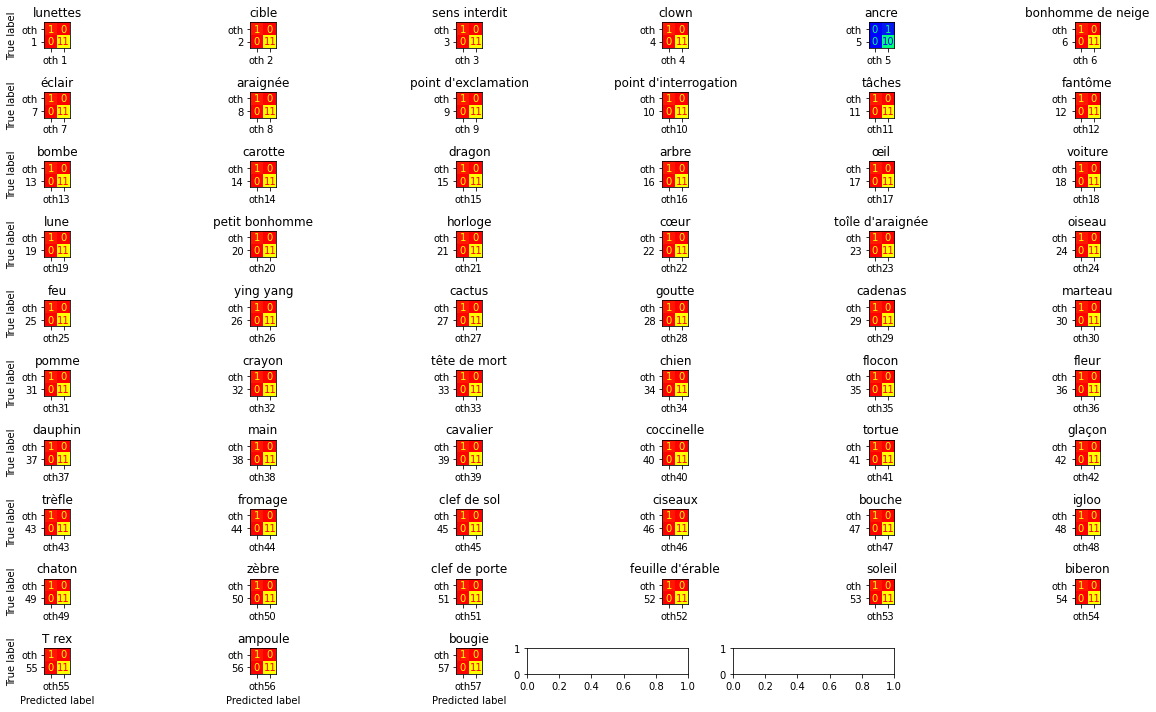

In [17]:
plot_confusion_matrix("./dataset/labels.txt", prediction, label_test)

Late fusion

In [18]:
clf_0 = RandomForestClassifier(max_depth=3)
clf_1 = RandomForestClassifier(max_depth=5)

In [19]:
color_feature_train = color_feature_extractor(img_train)
shape_feature_train = shape_feature_extractor(img_train)

color_feature_test = color_feature_extractor(img_test)
shape_feature_test = shape_feature_extractor(img_test)

train(clf_0, color_feature_train, label_train)
train(clf_1, shape_feature_train, label_train)

In [20]:
def soft_voting(color_predict_proba, shape_predict_proba):
    def get_max_proba_indices(color_predict_proba, shape_predict_proba):
        classes_pred_proba = 0.6 * color_predict_proba + 0.4 * shape_predict_proba
        return np.argmax(classes_pred_proba, axis=1)

    max_proba_indces = get_max_proba_indices(
        color_predict_proba, shape_predict_proba)
    
    return max_proba_indces + 1


color_labels = clf_0.predict(color_feature_test)
shape_labels = clf_1.predict(shape_feature_test)

prediction = soft_voting(clf_0.predict_proba(color_feature_test), clf_1.predict_proba(shape_feature_test))
accuracy = np.sum(np.array(prediction) ==np.array(label_test)) / len(prediction)
print(accuracy)

1.0


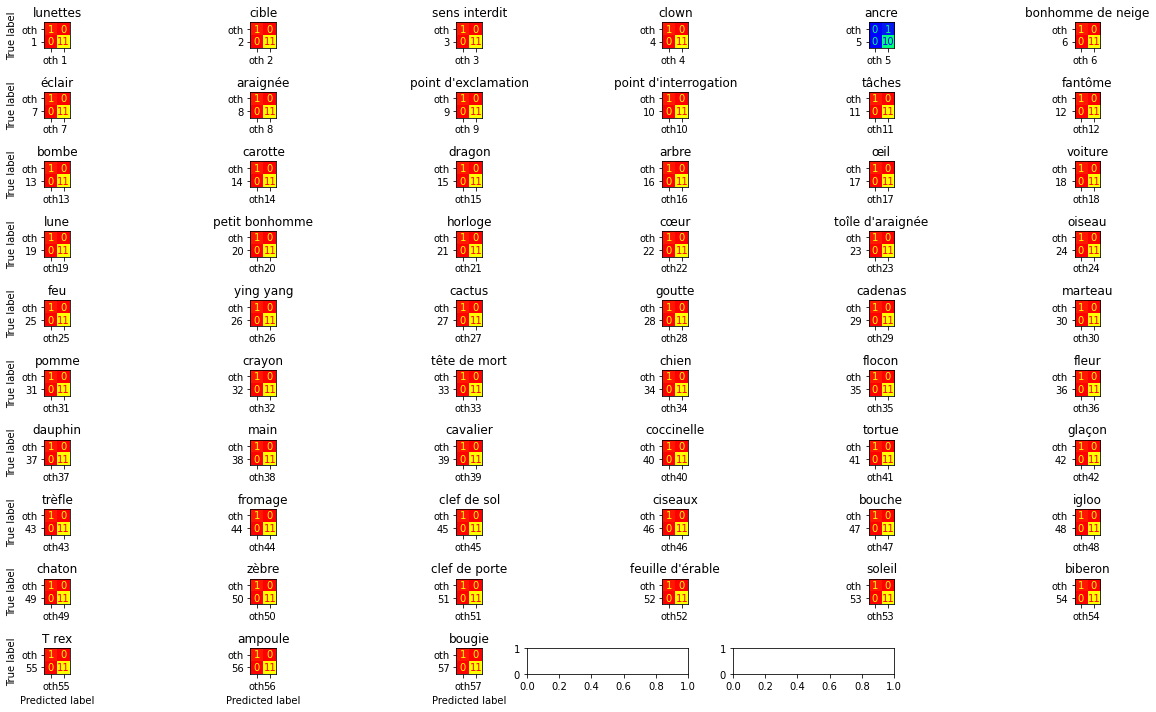

In [21]:
plot_confusion_matrix("./dataset/labels.txt", prediction, label_test)